<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/07/0704.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!wget -O consts.py https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/07/0704_consts.py?raw=1

## K-means on wine dataset & yellowbrick & cluster characterization

In [2]:
# sklearn imports
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# pandas and numpy imports
import pandas as pd
import numpy as np

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# yellowbrick libs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

from consts import WINE_FEATURES

# set sns theme and set pandas to display all rows and columns
sns.set_theme()

### Load wine dataset

The Wine dataset is a classic multivariate dataset used for classification tasks in machine learning.
- It consists of 178 samples of wine from three different cultivars (classes) in the same region in Italy.
- Each sample has 11 continuous attributes (features) that are the result of a chemical analysis of the wines.
- The goal of using this dataset is usually to build a classifier that can predict the cultivar of a wine based on its chemical composition.

The dataset contains following features:

- **Alcohol**: The alcohol content in the wine, measured in percentage.
- **Malic Acid**: The amount of malic acid in the wine.
- **Ash**: The measure of the non-aqueous residue remaining after heating.
- **Alcalinity of Ash**: A measure of the alkalinity of the ash formed post-combustion.
- **Magnesium**: The amount of magnesium in the wine.
- **Total Phenols**: The total amount of phenolic compounds.
- **Flavanoids**: Indicates the flavanoid phenolic content.
- **Nonflavanoid Phenols**: Measures the non-flavanoid phenolic content.
- **Proanthocyanins**: Indicates the proanthocyanin content.
- **Color Intensity**: The intensity of the wine's color, measured optically.
- **Hue**: The color attribute that describes a pure color, usually measured via spectrophotometry.
- **OD280/OD315 of diluted wines**: Measures the antioxidant content using absorbance ratio.
- **Proline**: The amount of the amino acid proline.

Citation : Aeberhard,Stefan and Forina,M.. (1991). Wine. UCI Machine Learning Repository. https://doi.org/10.24432/C5PC7J.

<ipython-input-3-623cf0e3e166>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = g.set_xticklabels(g.get_xticklabels(), rotation=90)


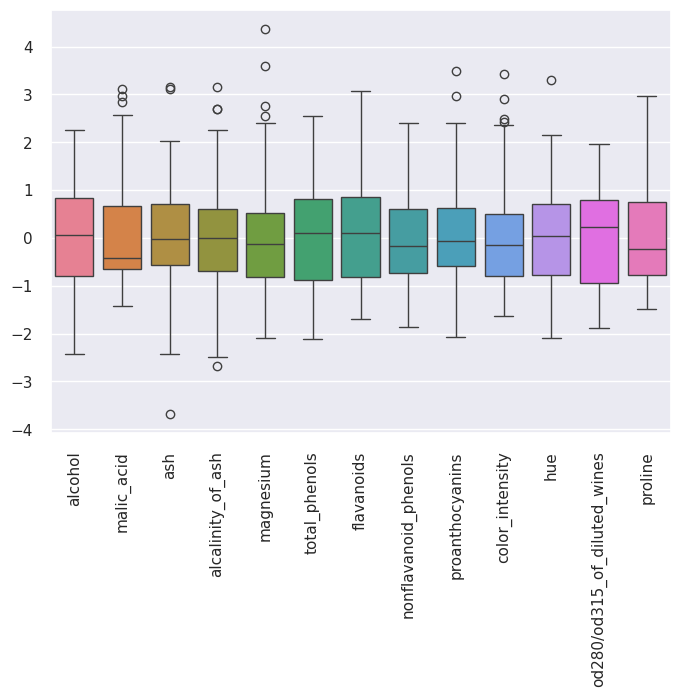

In [3]:
# Load the wine dataset
wine_data = load_wine()

wine_df_numeric = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)

wine_df = wine_df_numeric.copy()
wine_df['label'] = wine_data.target

# Scale the data
standard_scaler = StandardScaler()
standard_scaler.fit(wine_df_numeric)
wine_df_numeric_scaled = standard_scaler.transform(wine_df_numeric)

# Create data df
wine_df_numeric = pd.DataFrame(
    wine_df_numeric_scaled,
    columns = wine_df_numeric.columns
)

g = sns.boxplot(wine_df_numeric)
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)
# after the scaling all the features are on the same scale

### Run k-means with yellowbrick

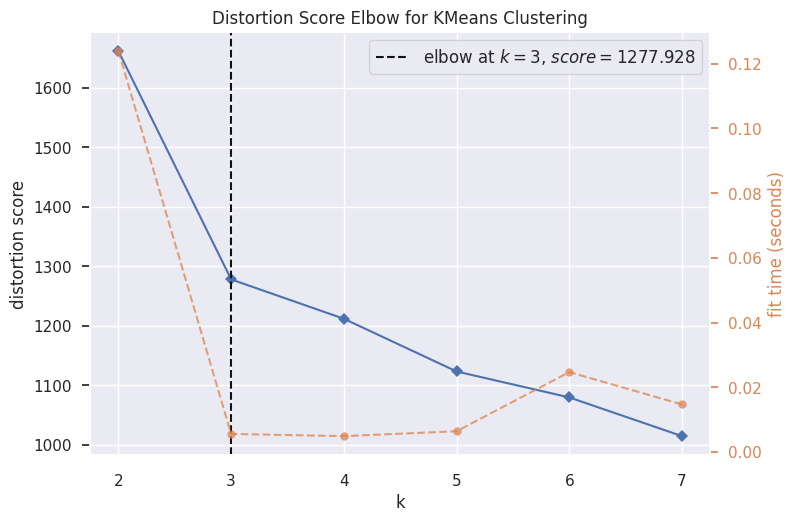

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [4]:
model = KMeans(n_init='auto', random_state=42)
visualizer = KElbowVisualizer(model, k=(2,3,4,5,6,7)) # default display the inertia values
visualizer=visualizer.fit(wine_df_numeric)
visualizer.show()

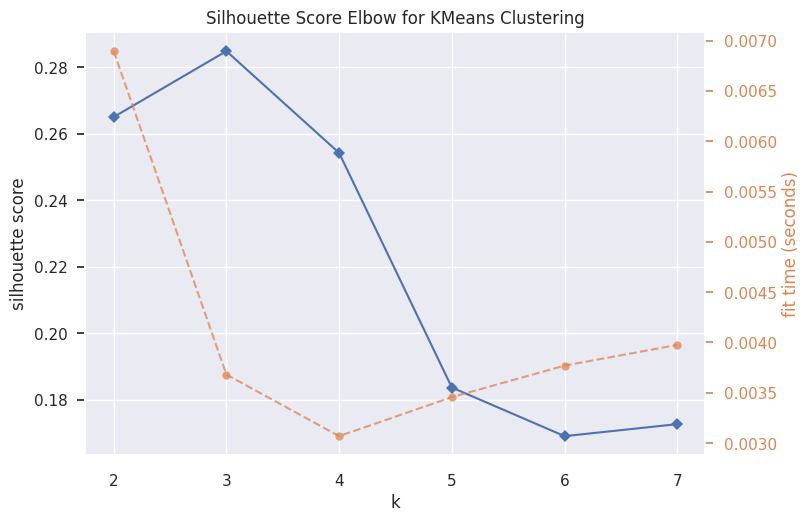

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [5]:
# we will have to rerun kmeans for all of these k values all over again
model = KMeans(n_init='auto', random_state=42)
visualizer = KElbowVisualizer(model, k=(2,3,4,5,6,7), metric='silhouette', locate_elbow=False)
visualizer=visualizer.fit(wine_df_numeric)   # Fit the data to the visualizer
visualizer.show()

Number of PCA components 13


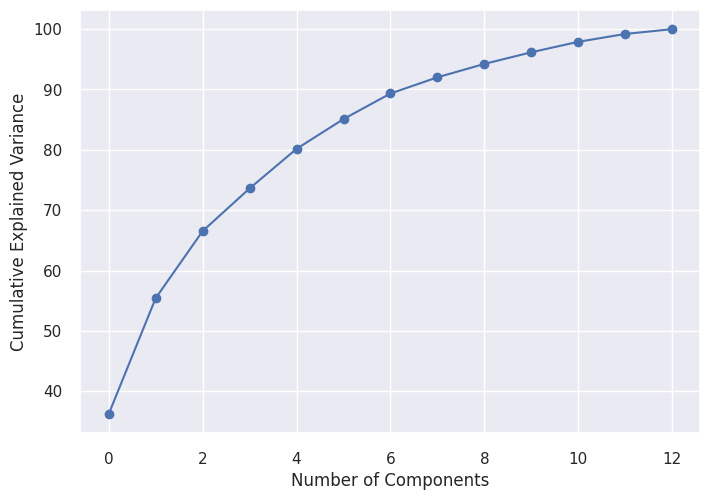

In [6]:
# Perform PCA
pca = PCA()
pca.fit(wine_df_numeric)
pca_transformed_data = pca.transform(wine_df_numeric)
print('Number of PCA components {}'.format(pca_transformed_data.shape[1]))
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)*100

plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)
plt.scatter(range(len(cumulative_explained_variance)),cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
# top 2 principal components explain big portion of the data set variance

In [7]:
# we will visualize clusterings for all the values of k, yielding a bigger values for the silhouette scores
candidate_k = [2,3,4,5]

In [8]:
# we will create a color palette, which we will use in order to have same colors on the scatter plot and on the silhouette plot
tab10 = list(matplotlib.colormaps['tab10'].colors)

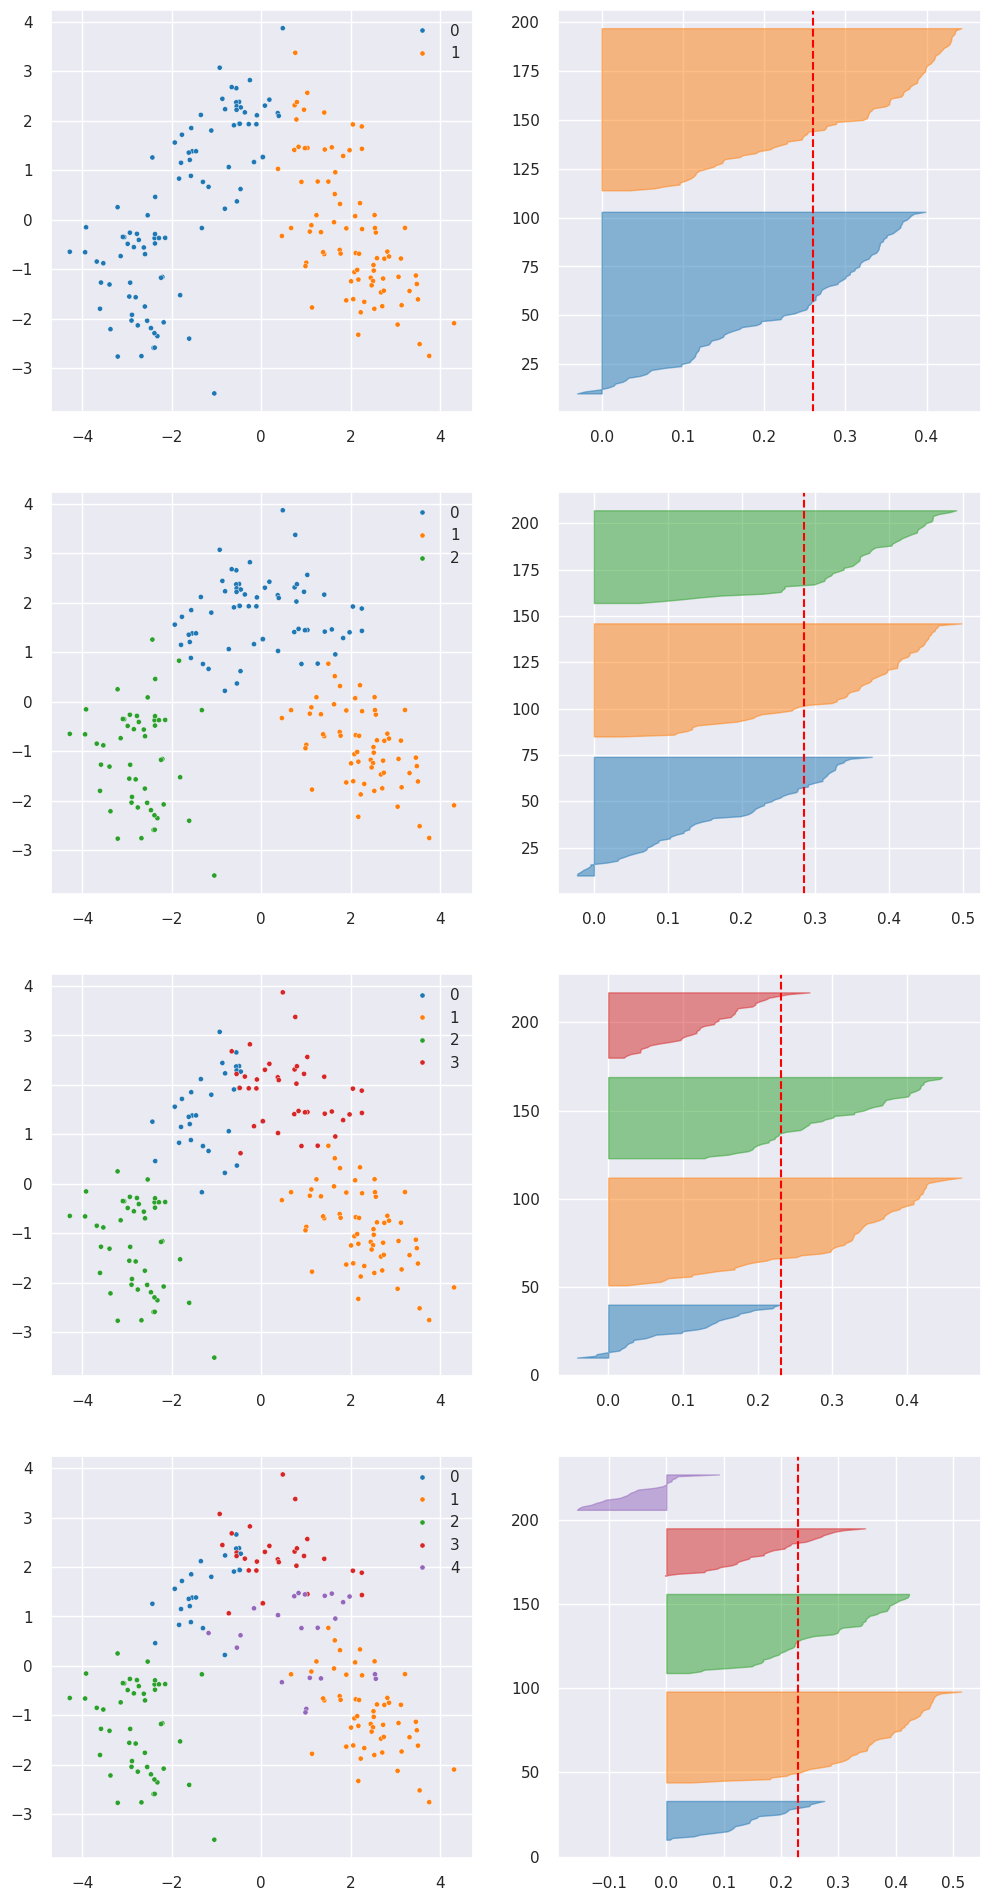

In [9]:
# Perform clustering for multiple resolutons
fig, axs = plt.subplots(
    len(candidate_k), 2,  # scatter plot, silhouette plot for each k
    figsize=(12, 24)
)

cluster_label_dict = {}
for i, num_clust in enumerate(candidate_k):
    # Perform clustering for current number of clusters
    kmeans = KMeans(n_clusters=num_clust, n_init='auto', random_state=2)
    kmeans.fit(wine_df_numeric.to_numpy())

    sns.scatterplot(
        x=pca_transformed_data[:,0],
        y=pca_transformed_data[:,1],
        hue=kmeans.labels_,
        ax=axs[i, 0],
        s=14, palette='tab10'
    )

    visualizer = SilhouetteVisualizer(
        kmeans,
        is_fitted=True,
        colors=tab10,
        ax=axs[i, 1]
    )
    visualizer = visualizer.fit(wine_df_numeric.to_numpy())

    cluster_label_dict[num_clust] = kmeans.labels_
# k=3 is the best

### Cluster characterization

In [10]:
from IPython.display import display, Markdown

alcohol - Measures the alcohol content in wine.
- Low (<11%): Lighter, potentially less body.
- Medium (11-14%): Balanced, more body and complexity.
- High (>14%): Fuller-bodied, may feel "hot" if not balanced.

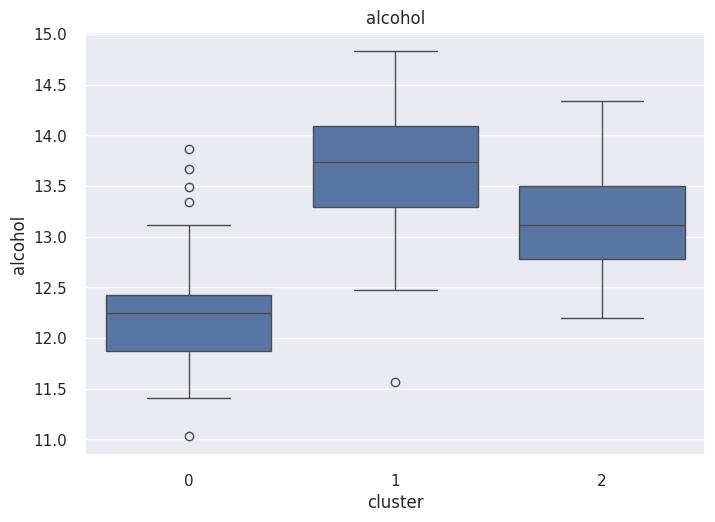

malic_acid - Indicates the acidity level from malic acid.
- Low (<0.2 g/L): Less tartness, potentially sweeter.
- High (>0.5 g/L): Tart, "green apple" like acidity.

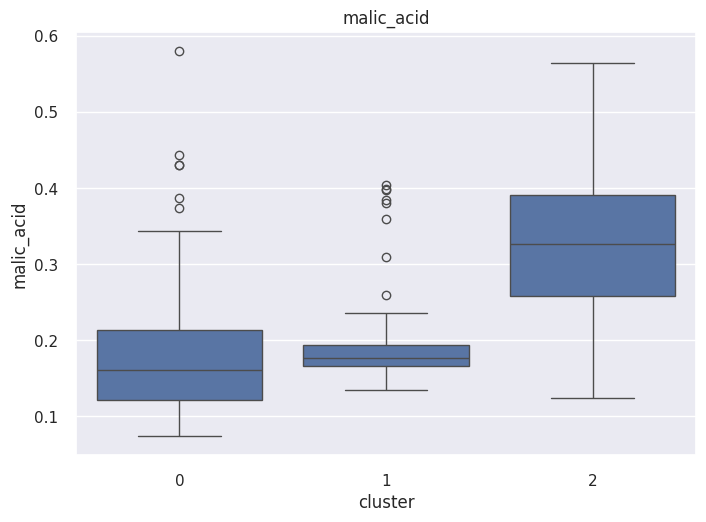

ash - Represents the non-volatile residue in wine.
- Typical range is 1.5-3.0 g/L; doesn't directly influence taste.

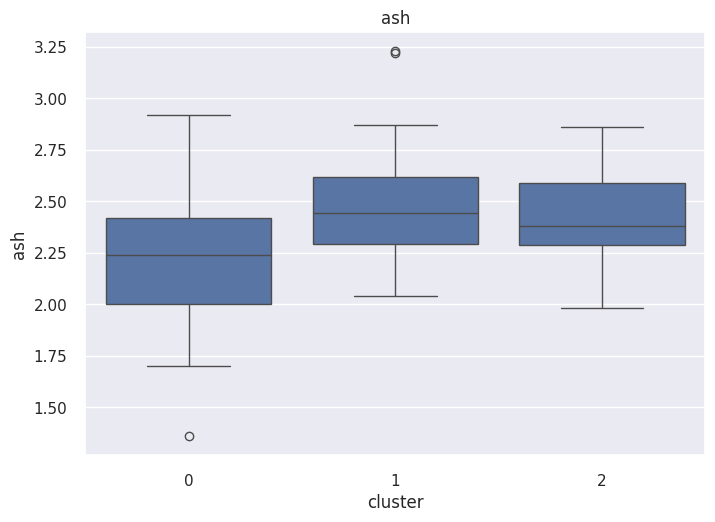

alcalinity_of_ash - Measures the alcalinity of the ash content.
- Low (<15): Higher acidity, crisp.
- High (>25): Lower acidity, might taste flat.

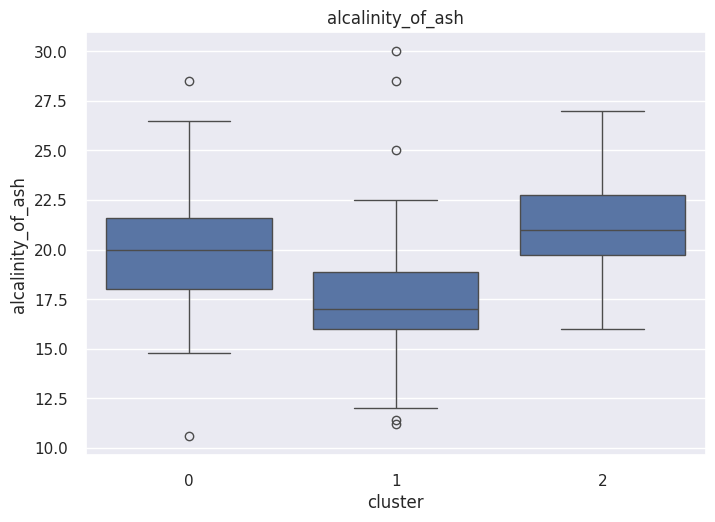

magnesium - Indicates the magnesium level in wine.
- Standard range 70-120 ppm; doesn't directly affect taste.

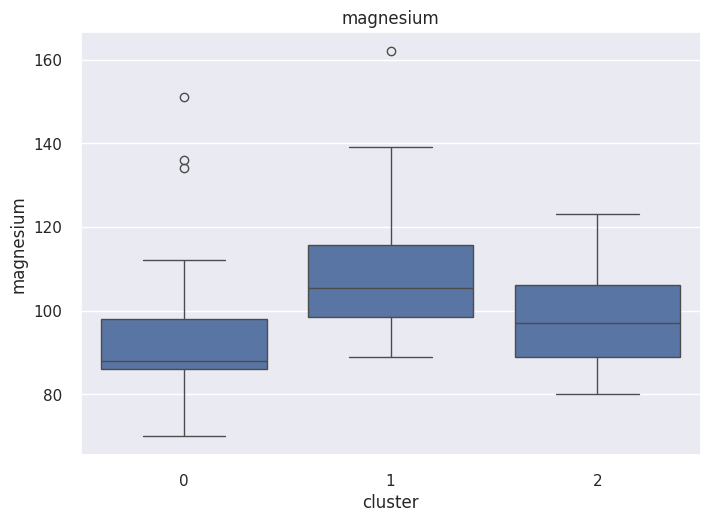

total_phenols - Represents the total phenolic content.
- Low (<500 mg/L): Less complex, might age poorly.
- High (>1500 mg/L): More complexity, better aging potential.

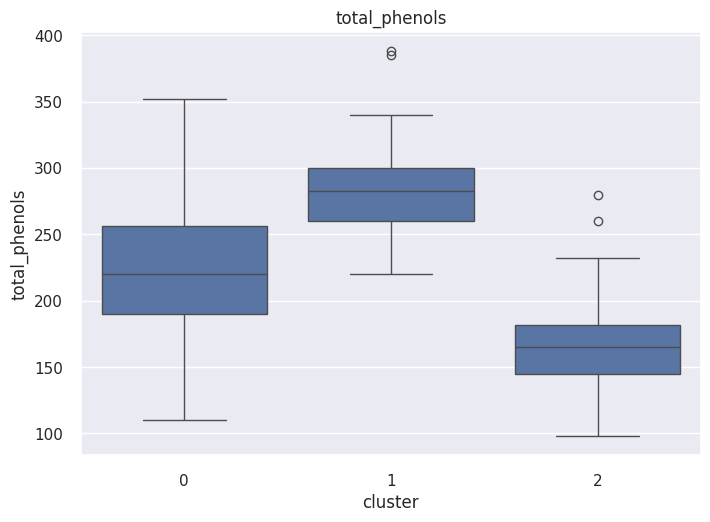

flavanoids - Indicates the flavanoid phenolic content.
- Low (<100 mg/L): Less complexity, poorer aging.
- High (>500 mg/L): More complexity, better aging potential.

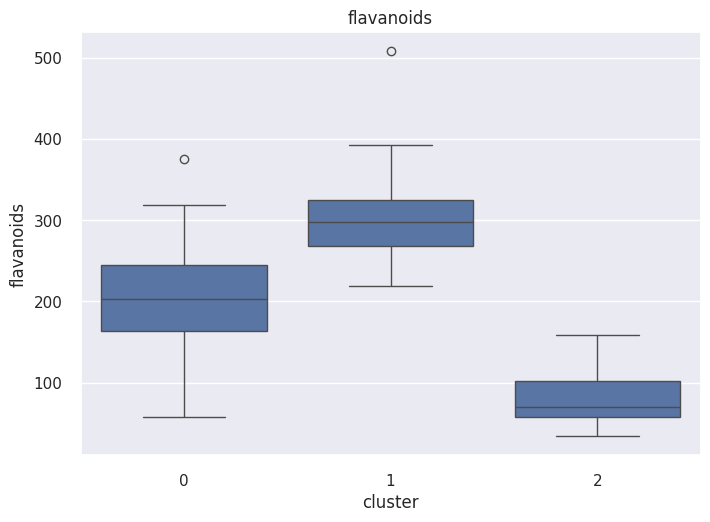

nonflavanoid_phenols - Measures the non-flavanoid phenolic content.
- Low (<20 mg/L): Better aging potential.
- High (>50 mg/L): Could affect mouthfeel negatively.

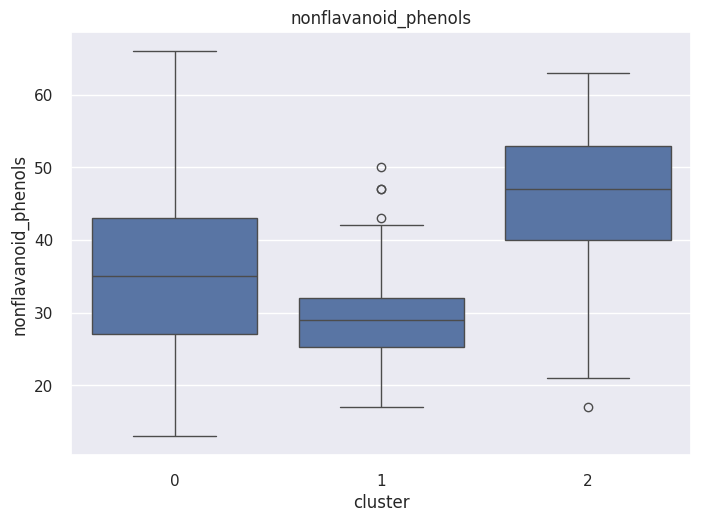

proanthocyanins - Indicates the proanthocyanin content.
- Low (<200 mg/L): Lighter color.
- High (>500 mg/L): Darker color, more aging potential.

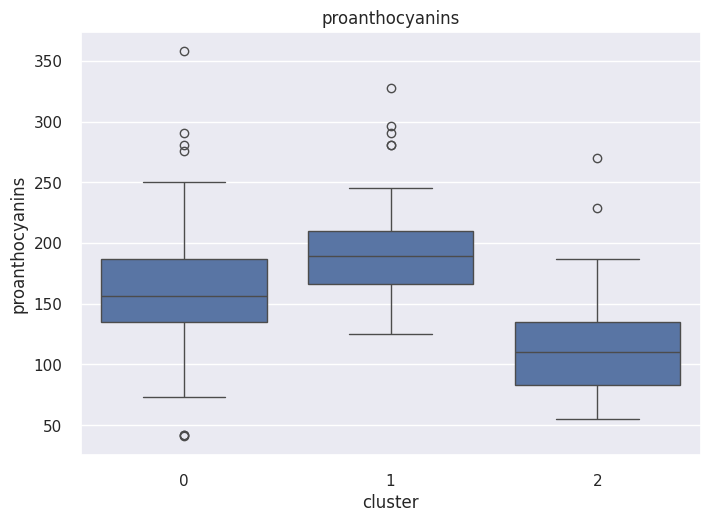

color_intensity - Measures the color intensity of the wine.
- Low: Lighter color, often lighter flavor.
- High: Darker color, often bolder flavor.

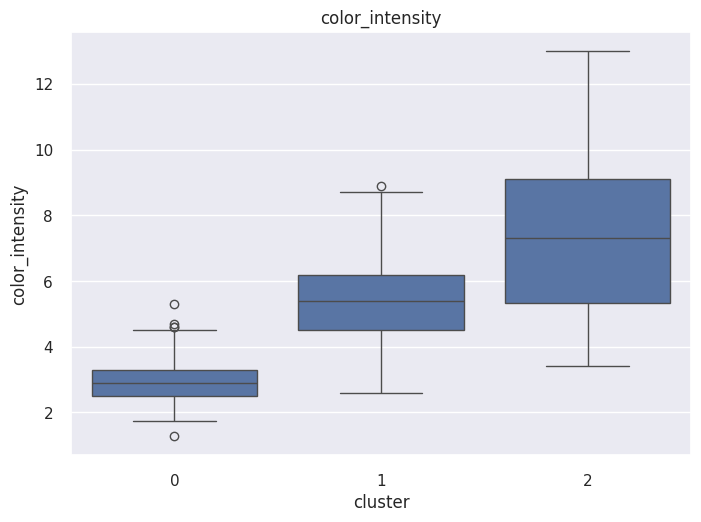

hue - Indicates the hue, or color tint, of the wine.
- Lower : Younger or less quality in red wines.
- High : Older, potentially higher quality especially in red wines.

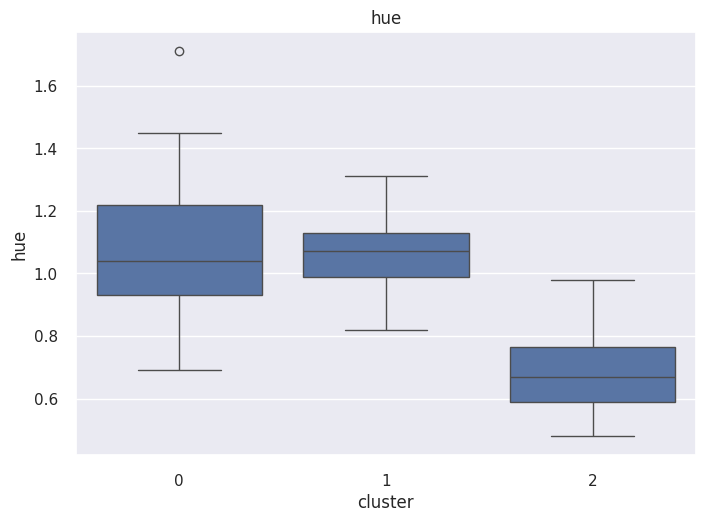

od280/od315_of_diluted_wines - Measures the antioxidant content using absorbance ratio.
- Low (<1.5): Lower antioxidant content.
- High (>3.0): Higher antioxidant content, might indicate better aging potential.

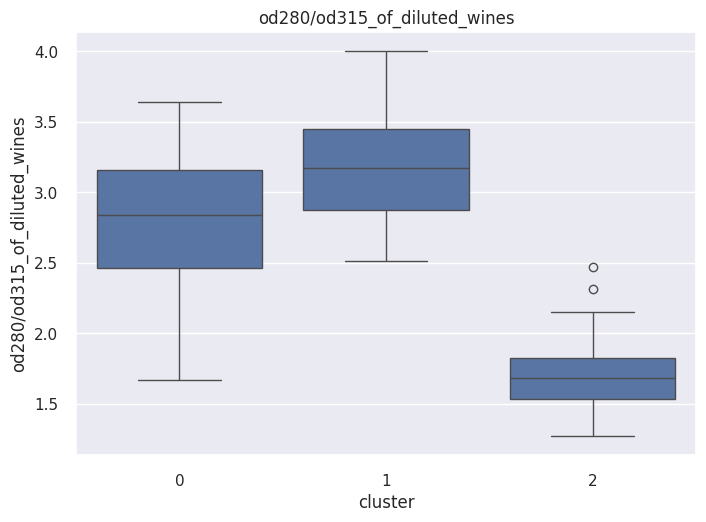

proline - Indicates the proline level, an amino acid.
- Low (<500 mg/L): Could indicate less ripe grapes or lower quality.
- High (>1000 mg/L): Could indicate riper grapes or higher quality.

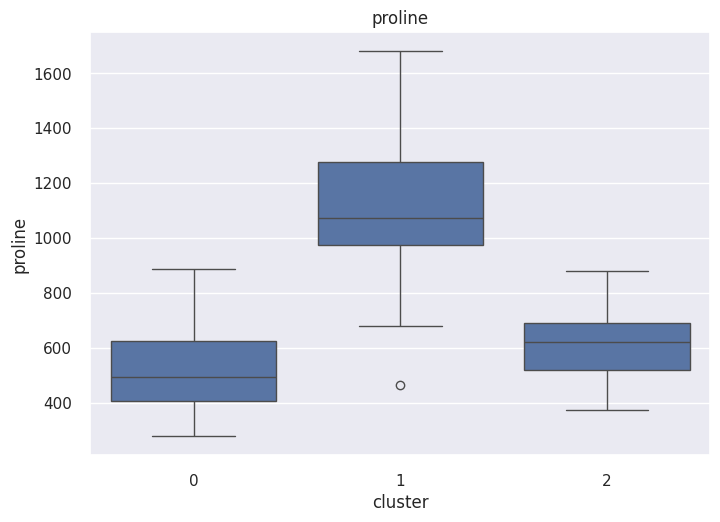

In [11]:
# Plot numerical features
# adjust these original feature values in order to make them compatible with their descriptions
wine_df['cluster'] = cluster_label_dict[3] # choose k=3
wine_df['malic_acid'] = wine_df['malic_acid']/10
wine_df['total_phenols'] = wine_df['total_phenols']*100
wine_df['flavanoids'] = wine_df['flavanoids']*100
wine_df['nonflavanoid_phenols'] = wine_df['nonflavanoid_phenols']*100
wine_df['proanthocyanins'] = wine_df['proanthocyanins']*100

for col in wine_df:
    if col not in ['label', 'cluster']:
        display(Markdown(col + ' - ' + WINE_FEATURES[col]))

        plt.figure()
        sns.boxplot(wine_df, x='cluster', y=col)
        plt.title(col)
        plt.show()